In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import glob
import os

# 1. Define the directory path containing the CSV files
# Replace '.' with your actual folder path if the files are elsewhere
folder_path = os.path.join('azure2', 'data')

# 2. Find all files starting with 'data_' and ending with '.csv'
search_pattern = os.path.join(folder_path, "data_*.csv")
all_files = glob.glob(search_pattern)

# 3. Sort files by name
# Since filenames are in 'YYYY-MM-DD_HH-MM-SS' format, sorting by name 
# automatically sorts them in chronological order.
all_files.sort()

print(f"Found {len(all_files)} files. Proceeding to merge...")

# 4. Read each file and append it to a list
li = []
for filename in all_files:
    print(f"Reading: {filename}")
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

# 5. Concatenate all DataFrames into one large DataFrame
# ignore_index=True resets the index, creating a continuous index from 0 to the end
if li:
    frame = pd.concat(li, axis=0, ignore_index=True)

    # 6. Export the result to a new CSV file
    output_filename = "data_merged_all.csv"
    frame.to_csv(output_filename, index=False)
    
    print(f"\nMerge complete! Output file: {output_filename}")
    print(f"Total rows: {len(frame)}")
else:
    print("No CSV files found in this directory.")

Found 29 files. Proceeding to merge...
Reading: azure2\data\data_2025-12-18_22-53-21.csv
Reading: azure2\data\data_2025-12-18_23-23-22.csv
Reading: azure2\data\data_2025-12-18_23-53-25.csv
Reading: azure2\data\data_2025-12-19_00-23-29.csv
Reading: azure2\data\data_2025-12-19_00-53-31.csv
Reading: azure2\data\data_2025-12-19_01-23-32.csv
Reading: azure2\data\data_2025-12-19_01-53-37.csv
Reading: azure2\data\data_2025-12-19_02-23-40.csv
Reading: azure2\data\data_2025-12-19_02-53-44.csv
Reading: azure2\data\data_2025-12-19_03-23-45.csv
Reading: azure2\data\data_2025-12-19_03-53-46.csv
Reading: azure2\data\data_2025-12-19_04-23-50.csv
Reading: azure2\data\data_2025-12-19_04-53-53.csv
Reading: azure2\data\data_2025-12-19_05-23-57.csv
Reading: azure2\data\data_2025-12-19_05-53-58.csv
Reading: azure2\data\data_2025-12-19_06-24-00.csv
Reading: azure2\data\data_2025-12-19_06-54-00.csv
Reading: azure2\data\data_2025-12-19_07-24-02.csv
Reading: azure2\data\data_2025-12-19_07-54-03.csv
Reading: az

In [13]:
import pandas as pd

# 1. Load the merged dataset
# We assume the file is in the current directory
input_file = "data_merged_all.csv"
print(f"Reading file: {input_file}...")
df = pd.read_csv(input_file)

# 2. Convert 'Timestamp' column to datetime objects
# This is crucial for comparing dates and times accurately
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 3. Define the cutoff timestamps provided by the user
cutoff_start = pd.to_datetime("2025-12-18 23:25:18")
cutoff_end   = pd.to_datetime("2025-12-19 11:02:33")

# 4. Split the data into 3 dataframes based on the timestamps

# Part 1: Baseline 1 (Data before the start time)
df_baseline1 = df[df['Timestamp'] < cutoff_start]

# Part 2: Measurement (Data between start and end times)
# inclusive of start time, exclusive or inclusive of end time as needed
df_measurement = df[(df['Timestamp'] >= cutoff_start) & (df['Timestamp'] <= cutoff_end)]

# Part 3: Baseline 2 (Data after the end time)
df_baseline2 = df[df['Timestamp'] > cutoff_end]

# 5. Export to 3 separate CSV files without the index column
print(f"Splitting data...")

# Save Baseline 1
df_baseline1.to_csv("baseline1.csv", index=False)
print(f" - Saved 'baseline1.csv' with {len(df_baseline1)} rows.")

# Save Measurement
df_measurement.to_csv("measurement.csv", index=False)
print(f" - Saved 'measurement.csv' with {len(df_measurement)} rows.")

# Save Baseline 2
df_baseline2.to_csv("baseline2.csv", index=False)
print(f" - Saved 'baseline2.csv' with {len(df_baseline2)} rows.")

print("Process complete!")

Reading file: data_merged_all.csv...
Splitting data...
 - Saved 'baseline1.csv' with 362 rows.
 - Saved 'measurement.csv' with 7936 rows.
 - Saved 'baseline2.csv' with 1409 rows.
Process complete!


In [14]:
import pandas as pd
import os

# 1. Load the datasets
file_measure = "measurement.csv"
file_base2 = "baseline2.csv"

# Check if files exist
if not os.path.exists(file_measure) or not os.path.exists(file_base2):
    print("Error: Files not found. Please ensure you have run the split script first.")
    exit()

print(f"Reading files: {file_measure} and {file_base2}...")
df_measure = pd.read_csv(file_measure)
df_base2 = pd.read_csv(file_base2)

# 2. Identify columns for processing
# Exclude environmental data and Timestamp from normalization logic
exclude_cols = ['Temp(C)', 'Hum(%)', 'Timestamp']

# Select numeric columns for sensors (MQ2, MQ3, etc.)
sensor_cols = [col for col in df_measure.select_dtypes(include=['float64', 'int64']).columns 
               if col not in exclude_cols]

print(f"Columns to normalize: {sensor_cols}")

# 3. Calculate Baseline 2 Means
baseline_means = df_base2[sensor_cols].mean()
print(f"Baseline offsets calculated.")

# 4. Normalize the Data
df_normalized = df_measure.copy()

# Subtract baseline mean from sensor columns only
df_normalized[sensor_cols] = df_measure[sensor_cols] - baseline_means

# ---------------------------------------------------------
# NEW STEP: ROUNDING TO 2 DECIMAL PLACES
# ---------------------------------------------------------
# Apply rounding to all numeric columns in the DataFrame
df_normalized = df_normalized.round(2)

# 5. Export the result
output_file = "measurement_normalized_selective_rounded.csv"
df_normalized.to_csv(output_file, index=False)

print("\n" + "="*50)
print(f"Process Complete! Output saved to: {output_file}")
print("="*50)

# ---------------------------------------------------------
# VERIFICATION
# ---------------------------------------------------------
print("\nVerifying data (First row comparison):")
print(f"{'Column':<10} | {'Original':<10} | {'Baseline Mean':<15} | {'Final (Rounded)':<15} | {'Status'}")
print("-" * 80)

# Check a Sensor column
if len(sensor_cols) > 0:
    test_sensor = sensor_cols[0]
    orig_s = df_measure[test_sensor].iloc[0]
    base_s = baseline_means[test_sensor]
    new_s  = df_normalized[test_sensor].iloc[0]
    print(f"{test_sensor:<10} | {orig_s:<10.4f} | {base_s:<15.4f} | {new_s:<15} | Normalized")

# Check Temp(C)
if 'Temp(C)' in df_measure.columns:
    orig_t = df_measure['Temp(C)'].iloc[0]
    new_t  = df_normalized['Temp(C)'].iloc[0]
    # Note: original might have more decimals, new one should have max 2
    print(f"{'Temp(C)':<10} | {orig_t:<10.4f} | {'N/A':<15} | {new_t:<15} | Kept Original")

Reading files: measurement.csv and baseline2.csv...
Columns to normalize: ['MQ2(V)', 'MQ3(V)', 'MQ5(V)', 'MQ7(V)', 'MQ8(V)', 'MQ135(V)']
Baseline offsets calculated.

Process Complete! Output saved to: measurement_normalized_selective_rounded.csv

Verifying data (First row comparison):
Column     | Original   | Baseline Mean   | Final (Rounded) | Status
--------------------------------------------------------------------------------
MQ2(V)     | 0.7300     | 0.4102          | 0.32            | Normalized
Temp(C)    | 42.5000    | N/A             | 42.5            | Kept Original


Loading files: measurement_normalized_selective_rounded_1.csv and measurement_normalized_selective_rounded_2.csv...
Analyzing columns: ['Temp(C)', 'Hum(%)', 'MQ2(V)', 'MQ3(V)', 'MQ5(V)', 'MQ7(V)', 'MQ8(V)', 'MQ135(V)']

STATISTICAL COMPARISON (MEAN & STD)
          Mean_1  Mean_2  Std_1  Std_2  Diff_Mean
Temp(C)    39.40   43.50   1.13   1.03      -4.10
Hum(%)     39.29   35.18   1.12   1.11       4.11
MQ2(V)      0.23    0.04   0.07   0.06       0.19
MQ3(V)      0.62    0.86   0.14   0.25      -0.24
MQ5(V)      0.24    0.33   0.09   0.15      -0.09
MQ7(V)      0.03    0.14   0.02   0.08      -0.11
MQ8(V)      0.50    0.19   0.18   0.11       0.31
MQ135(V)    0.12    0.09   0.05   0.19       0.04
------------------------------------------------------------
Note: 'Diff_Mean' = Mean_1 - Mean_2

Generating Box Plots...


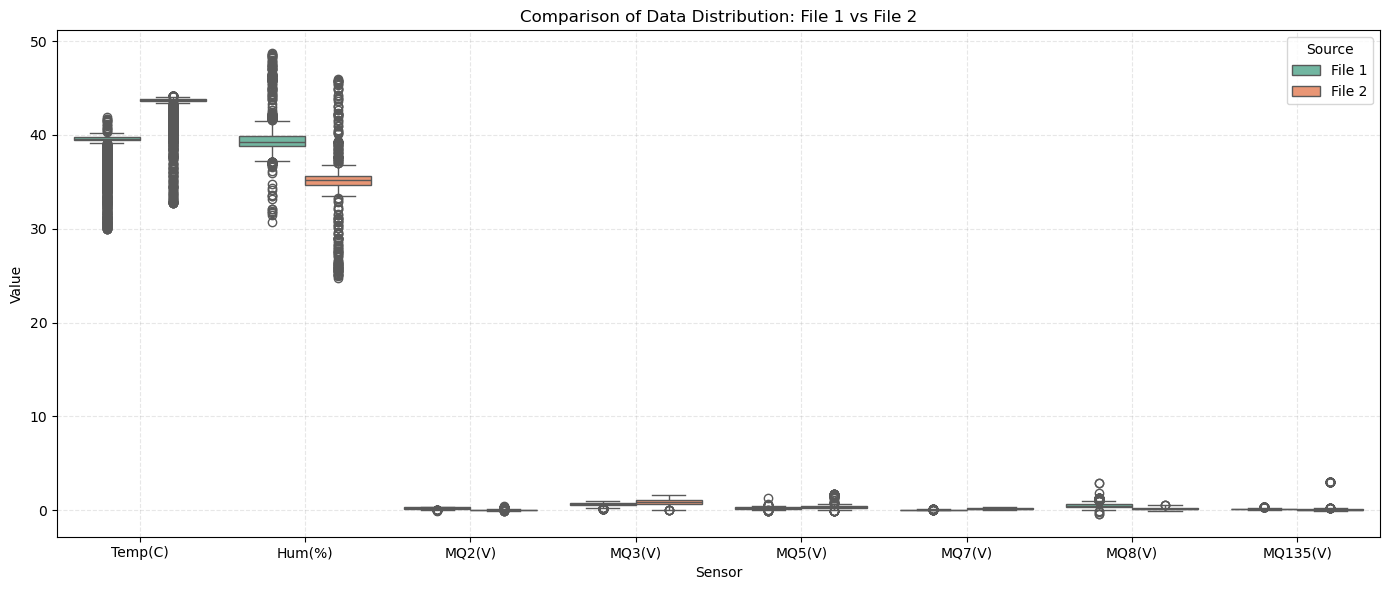

Generating Time Series Plots...


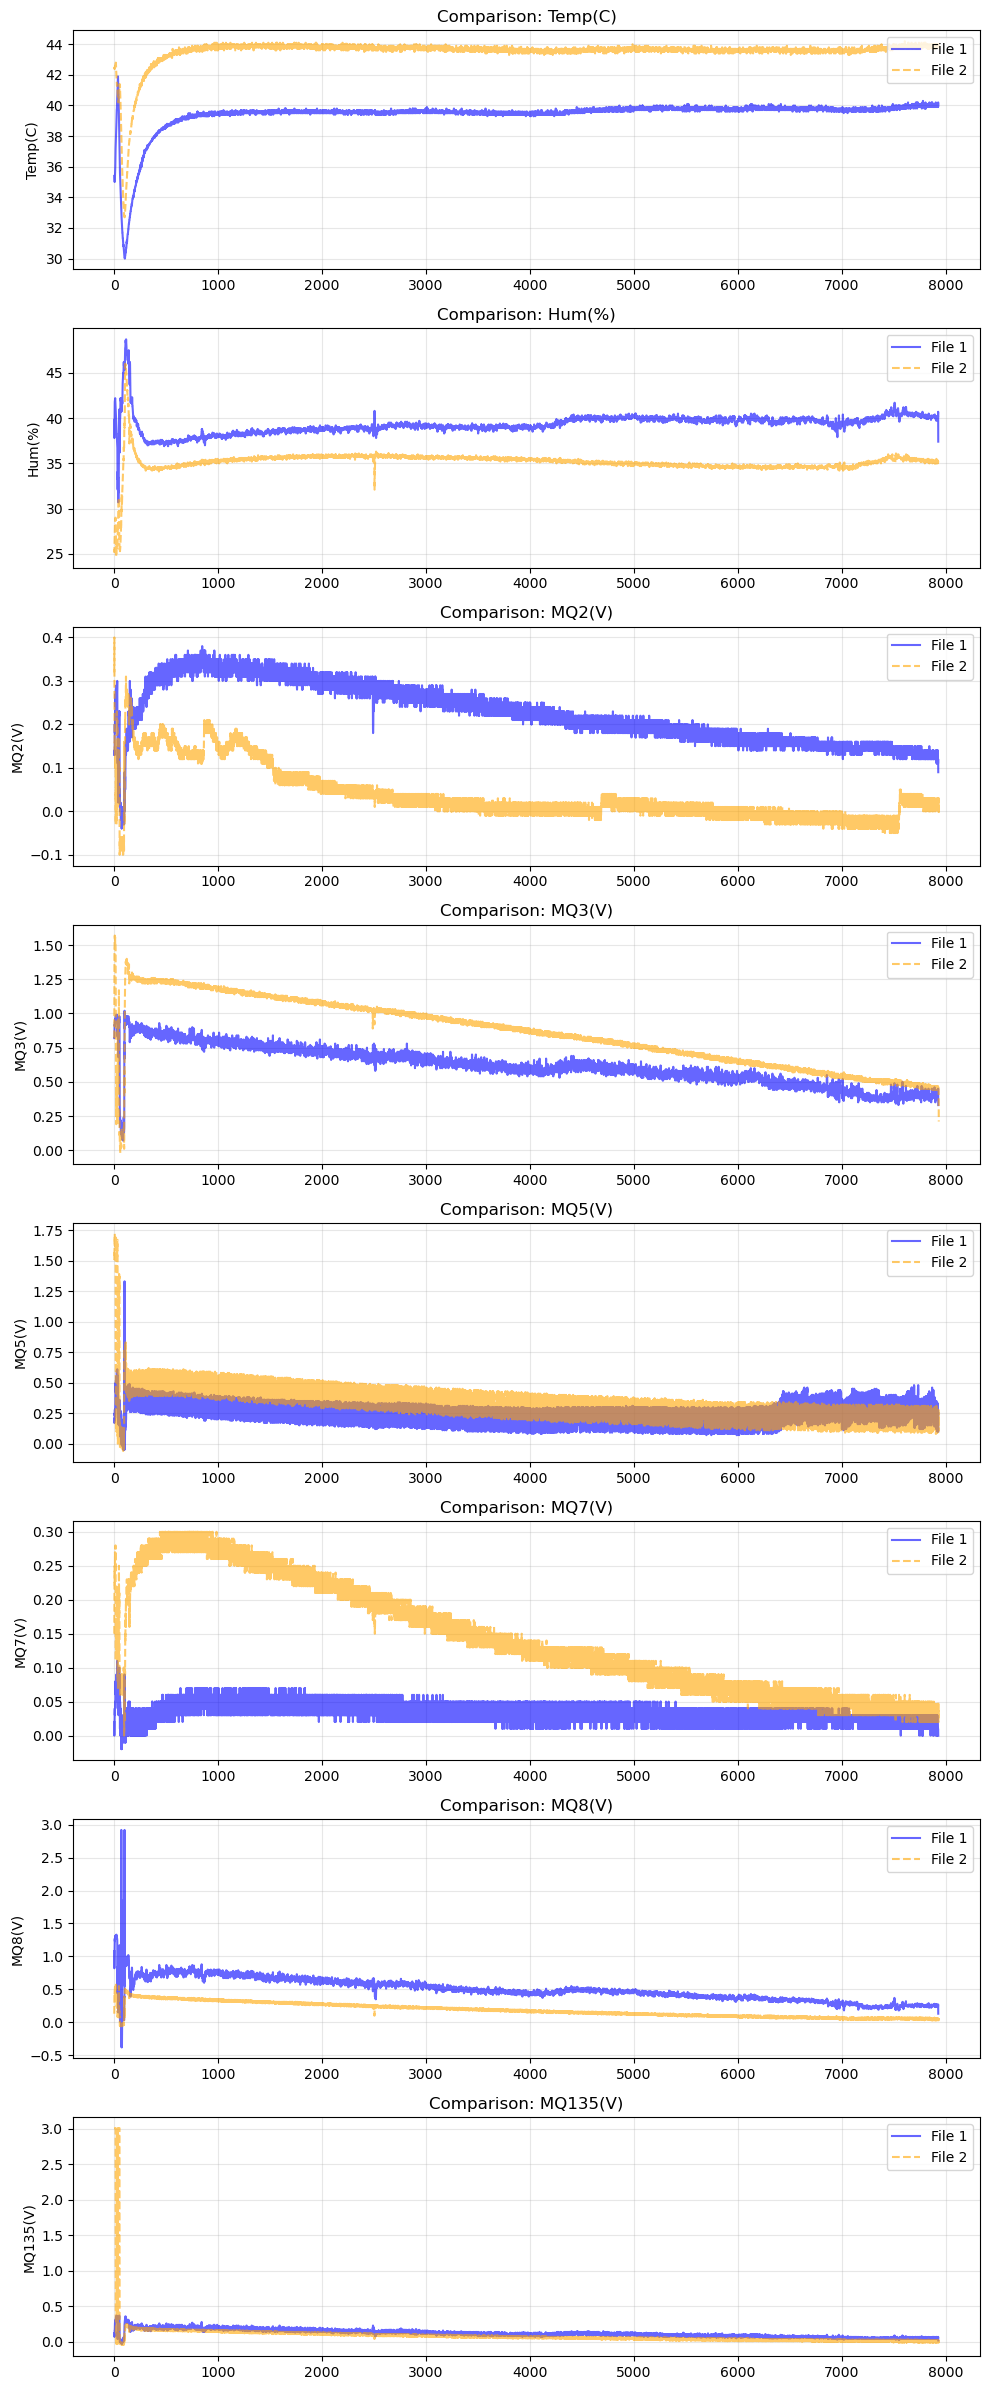

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Setup file paths
file_1 = "measurement_normalized_selective_rounded_1.csv"
file_2 = "measurement_normalized_selective_rounded_2.csv"

# Check if files exist
if not os.path.exists(file_1) or not os.path.exists(file_2):
    print(f"Error: One or both files not found ({file_1}, {file_2}).")
    print("Please make sure the files are in the same folder as this script.")
    exit()

print(f"Loading files: {file_1} and {file_2}...")
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)

# 2. Preprocessing
# Convert Timestamp if it exists (for line plotting)
if 'Timestamp' in df1.columns: df1['Timestamp'] = pd.to_datetime(df1['Timestamp'])
if 'Timestamp' in df2.columns: df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])

# Identify numeric columns for analysis (Sensors, Temp, Hum)
# We assume both files have the same structure, so we take columns from df1
numeric_cols = df1.select_dtypes(include=['float64', 'int64']).columns.tolist()

print(f"Analyzing columns: {numeric_cols}")

# ---------------------------------------------------------
# PART 1: STATISTICAL COMPARISON TABLE
# ---------------------------------------------------------
print("\n" + "="*60)
print("STATISTICAL COMPARISON (MEAN & STD)")
print("="*60)

# Calculate Mean and Std for File 1
stats1 = df1[numeric_cols].agg(['mean', 'std']).T
stats1.columns = ['Mean_1', 'Std_1']

# Calculate Mean and Std for File 2
stats2 = df2[numeric_cols].agg(['mean', 'std']).T
stats2.columns = ['Mean_2', 'Std_2']

# Combine into a single table
comparison = pd.concat([stats1, stats2], axis=1)

# Reorder columns for easier reading: Mean_1 vs Mean_2, Std_1 vs Std_2
comparison = comparison[['Mean_1', 'Mean_2', 'Std_1', 'Std_2']]

# Calculate the difference (Delta)
comparison['Diff_Mean'] = comparison['Mean_1'] - comparison['Mean_2']

print(comparison.round(2))
print("-" * 60)
print("Note: 'Diff_Mean' = Mean_1 - Mean_2")

# ---------------------------------------------------------
# PART 2: VISUALIZATION - BOX PLOT (DISTRIBUTION)
# ---------------------------------------------------------
print("\nGenerating Box Plots...")

# Add a label column to distinguish datasets
df1['Dataset'] = 'File 1'
df2['Dataset'] = 'File 2'

# Combine data for plotting
df_combined = pd.concat([df1, df2], ignore_index=True)

# Melt data to long format for Seaborn
df_melted = df_combined.melt(id_vars=['Dataset'], value_vars=numeric_cols, 
                             var_name='Sensor', value_name='Value')

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_melted, x='Sensor', y='Value', hue='Dataset', palette="Set2")

plt.title("Comparison of Data Distribution: File 1 vs File 2")
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title="Source")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# PART 3: VISUALIZATION - TIME SERIES (OVERLAY)
# ---------------------------------------------------------
print("Generating Time Series Plots...")

# Use only common columns
cols_to_plot = [c for c in numeric_cols if c in df1.columns and c in df2.columns]
num_vars = len(cols_to_plot)

fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 3 * num_vars), sharex=False)
if num_vars == 1: axes = [axes]

for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    
    # Plot File 1
    # We use reset_index() or just index if Timestamps don't match or overlap incorrectly
    # Using simple index (0, 1, 2...) allows comparing 'shapes' even if times are different
    ax.plot(df1.index, df1[col], label='File 1', color='blue', alpha=0.6)
    
    # Plot File 2
    ax.plot(df2.index, df2[col], label='File 2', color='orange', alpha=0.6, linestyle='--')
    
    ax.set_title(f"Comparison: {col}")
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()